In [29]:
import os
import json
import random
import cv2
import numpy as np
from skimage import measure
from shapely.geometry import Polygon, MultiPolygon
import zlib
import base64
from tqdm import tqdm
import shutil
import matplotlib.pyplot as plt

In [2]:
# Kaggle Paths
originaldatapath = '/kaggle/input/trashcan/dataset/original_data'
annotationspath = '/kaggle/input/trashcan/dataset/original_data/annotations'
imagespath = '/kaggle/input/trashcan/dataset/original_data/images'
outputpath = '/kaggle/working/'

In [3]:
# Global variables
annotation_id = 1
image_id = 1
is_crowd = 0

In [4]:
def base64_2_mask(s):
    z = zlib.decompress(base64.b64decode(s))
    n = np.frombuffer(z, np.uint8)
    mask = cv2.imdecode(n, cv2.IMREAD_UNCHANGED)[:, :, 3].astype(np.float32)
    return mask

In [5]:
def submask_2_mask(submask, origin, height, width):
    mask = np.zeros((height+2, width+2), np.float32)
    ox = int(origin[0]+1)
    oy = int(origin[1]+1)
    hy, wx = submask.shape
    mask[oy:oy+hy, ox:ox+wx] = submask
    return mask

In [6]:
def create_mask_annotation(im_name, mask, image_id, category_id, annotation_id, is_crowd):
    contours = measure.find_contours(mask, 0.5, positive_orientation='low')

    segmentations = []
    polygons = []

    for contour in contours:
        for i in range(len(contour)):
            row, col = contour[i]
            contour[i] = (col, row)

        poly = Polygon(contour)
        poly = poly.simplify(1.0, preserve_topology=False)

        if poly.is_empty:
            continue

        if poly.geom_type == 'MultiPolygon':
            poly = poly.convex_hull

        if poly.geom_type == 'Polygon':
            polygons.append(poly)
            segmentation = np.array(poly.exterior.coords).ravel().tolist()
            if segmentation:
                segmentations.append(segmentation)

    multi_poly = MultiPolygon(polygons)
    x, y, max_x, max_y = multi_poly.bounds
    width = max_x - x
    height = max_y - y
    bbox = (x, y, width, height)
    area = multi_poly.area

    annotation = {
        'segmentation': segmentations,
        'iscrowd': is_crowd,
        'image_id': image_id,
        'category_id': category_id,
        'id': annotation_id,
        'bbox': bbox,
        'area': area
    }

    return annotation

In [7]:
def create_image_entry(file_name, im_id, width, height):
    return {
        "file_name": file_name,
        "height": height,
        "width": width,
        "id": im_id
    }

In [8]:
def get_category_id(obj, dataset_version):
    if obj['geometryType'] != 'bitmap':
        return None

    class_title = str(obj['classTitle'])

    if class_title == 'rov':
        return 1
    elif class_title == 'unknown':
        return 9 if dataset_version == 'material' else 17
    elif class_title == 'bio':
        for tag in obj['tags']:
            if tag['name'] == 'plant':
                return 2
            elif tag['name'] == 'animal':
                animal_type = str(tag['value'])
                if animal_type in ['fish', '0']:
                    return 3
                elif animal_type in ['starfish', 'satrfish', '3']:
                    return 4
                elif animal_type in ['shell', 'shells', '4']:
                    return 5
                elif animal_type in ['crab', ' crab', '2']:
                    return 6
                elif animal_type in ['eel', 'ee;', '1']:
                    return 7
                else:
                    return 8
    elif class_title == 'trash':
        if dataset_version == 'material':
            for tag in obj['tags']:
                if tag['name'] == 'material':
                    material = str(tag['value'])
                    if material == 'fabric':
                        return 10
                    elif material == 'fishing_gear':
                        return 11
                    elif material == 'metal':
                        return 12
                    elif material == 'paper':
                        return 13
                    elif material == 'plastic':
                        return 14
                    elif material == 'rubber':
                        return 15
                    elif material == 'wood':
                        return 16
            return 9  # trash_etc
        else:  # instance version
            for tag in obj['tags']:
                if tag['name'] == 'instance':
                    instance = str(tag['value'])
                    if instance in ['clothing', '0']:
                        return 9
                    elif instance in ['pipe', '1']:
                        return 10
                    elif instance in ['bottle', '2']:
                        return 11
                    elif instance in ['bag', 'bags', '3']:
                        return 12
                    elif instance in ['snack_wrapper', '4']:
                        return 13
                    elif instance in ['can', 'cab', '5']:
                        return 14
                    elif instance in ['cup', '6']:
                        return 15
                    elif instance in ['container', '7']:
                        return 16
                    elif instance in ['branch', '9']:
                        return 18
                    elif instance in ['wreakage', 'wreckage', '10']:
                        return 19
                    elif instance in ['tarp', 'trap', '11']:
                        return 20
                    elif instance in ['rope', '12']:
                        return 21
                    elif instance in ['net', 'network', '13']:
                        return 22
            return 17  # trash_unknown_instance

    return None

In [9]:
def process_annotations(file_list, set_type, dataset_version):
    global annotation_id, image_id

    annotations = []
    images = []
    obj_dict = {}

    for ann_file in tqdm(file_list):
        with open(os.path.join(annotationspath, ann_file)) as json_file:
            data = json.load(json_file)

            width = int(data['size']['width'])
            height = int(data['size']['height'])

            objects = data['objects']
            for obj in objects:
                category_id = get_category_id(obj, dataset_version)
                if category_id is None:
                    continue

                obj_dict[category_id] = obj_dict.get(category_id, 0) + 1

                submask = base64_2_mask(obj['bitmap']['data'])
                origin = obj['bitmap']['origin']
                mask = submask_2_mask(submask, origin, height, width)

                annotation = create_mask_annotation(ann_file[:-5], mask, image_id, category_id, annotation_id, is_crowd)
                if annotation:
                    annotations.append(annotation)
                    annotation_id += 1

            # Copy image to output directory
            output_image_path = os.path.join(outputpath, f'{dataset_version}_version', set_type)
            os.makedirs(output_image_path, exist_ok=True)
            shutil.copy(os.path.join(imagespath, ann_file[:-5]), os.path.join(output_image_path, ann_file[:-5]))
            
            images.append(create_image_entry(ann_file[:-5], image_id, width, height))
            image_id += 1

    return annotations, images, obj_dict

In [10]:
def create_coco_json(annotations, images, set_type, dataset_version):
    categories = [
        {"supercategory": "rov", "id": 1, "name": "rov"},
        {"supercategory": "plant", "id": 2, "name": "plant"},
        {"supercategory": "animal_fish", "id": 3, "name": "animal_fish"},
        {"supercategory": "animal_starfish", "id": 4, "name": "animal_starfish"},
        {"supercategory": "animal_shells", "id": 5, "name": "animal_shells"},
        {"supercategory": "animal_crab", "id": 6, "name": "animal_crab"},
        {"supercategory": "animal_eel", "id": 7, "name": "animal_eel"},
        {"supercategory": "animal_etc", "id": 8, "name": "animal_etc"},
    ]

    if dataset_version == 'material':
        categories.extend([
            {"supercategory": "trash_etc", "id": 9, "name": "trash_etc"},
            {"supercategory": "trash_fabric", "id": 10, "name": "trash_fabric"},
            {"supercategory": "trash_fishing_gear", "id": 11, "name": "trash_fishing_gear"},
            {"supercategory": "trash_metal", "id": 12, "name": "trash_metal"},
            {"supercategory": "trash_paper", "id": 13, "name": "trash_paper"},
            {"supercategory": "trash_plastic", "id": 14, "name": "trash_plastic"},
            {"supercategory": "trash_rubber", "id": 15, "name": "trash_rubber"},
            {"supercategory": "trash_wood", "id": 16, "name": "trash_wood"}
        ])
    else:
        categories.extend([
            {"supercategory": "trash_clothing", "id": 9, "name": "trash_clothing"},
            {"supercategory": "trash_pipe", "id": 10, "name": "trash_pipe"},
            {"supercategory": "trash_bottle", "id": 11, "name": "trash_bottle"},
            {"supercategory": "trash_bag", "id": 12, "name": "trash_bag"},
            {"supercategory": "trash_snack_wrapper", "id": 13, "name": "trash_snack_wrapper"},
            {"supercategory": "trash_can", "id": 14, "name": "trash_can"},
            {"supercategory": "trash_cup", "id": 15, "name": "trash_cup"},
            {"supercategory": "trash_container", "id": 16, "name": "trash_container"},
            {"supercategory": "trash_unknown_instance", "id": 17, "name": "trash_unknown_instance"},
            {"supercategory": "trash_branch", "id": 18, "name": "trash_branch"},
            {"supercategory": "trash_wreckage", "id": 19, "name": "trash_wreckage"},
            {"supercategory": "trash_tarp", "id": 20, "name": "trash_tarp"},
            {"supercategory": "trash_rope", "id": 21, "name": "trash_rope"},
            {"supercategory": "trash_net", "id": 22, "name": "trash_net"}
        ])

    coco_data = {
        "info": {
            "description": "TrashCAN Segmentation Dataset",
            "url": "N/A",
            "version": "0.5",
            "year": 2020,
            "contributor": "IRVLab",
            "date_created": "2020/6/24"
        },
        "licenses": [
            {
                "url": "http://creativecommons.org/licenses/by-nc-sa/2.0/",
                "id": 1,
                "name": "Attribution-NonCommercial-ShareAlike License"
            }
        ],
        "categories": categories,
        "images": images,
        "annotations": annotations
    }

    output_json_path = os.path.join(outputpath, f'{dataset_version}_version')
    os.makedirs(output_json_path, exist_ok=True)
    with open(os.path.join(output_json_path, f'instances_{set_type}_trashcan.json'), 'w') as f:
        json.dump(coco_data, f, indent=2)

In [11]:
def main(dataset_version):
    # Get all annotation files
    all_files = [f for f in os.listdir(annotationspath) if f.endswith('.jpg.json')]

    # Split into train and val
    random.shuffle(all_files)
    split = int(0.8 * len(all_files))
    train_files = all_files[:split]
    val_files = all_files[split:]

    # Process train and val sets
    train_annotations, train_images, train_obj_dict = process_annotations(train_files, 'train', dataset_version)
    val_annotations, val_images, val_obj_dict = process_annotations(val_files, 'val', dataset_version)

    # Create COCO JSON files
    create_coco_json(train_annotations, train_images, 'train', dataset_version)
    create_coco_json(val_annotations, val_images, 'val', dataset_version)

    # Print summary
    print(f"Dataset Version: {dataset_version}")
    print(f"Total Images: {len(all_files)}")
    print(f"Training Images: {len(train_files)}")
    print(f"Validation Images: {len(val_files)}")
    print("\nClass Distribution:")
    print("Class ID | Train | Val")
    print("---------+-------+-----")
    for class_id in range(1, 23 if dataset_version == 'instance' else 17):
        train_count = train_obj_dict.get(class_id, 0)
        val_count = val_obj_dict.get(class_id, 0)
        print(f"{class_id:8d} | {train_count:5d} | {val_count:3d}")

if __name__ == '__main__':
    dataset_version = input("Enter dataset version (material or instance): ").lower()
    if dataset_version not in ['material', 'instance']:
        print("Invalid dataset version. Please enter 'material' or 'instance'.")
    else:
        main(dataset_version)

Enter dataset version (material or instance):  instance


100%|██████████| 1443/1443 [00:21<00:00, 66.09it/s]


Dataset Version: instance
Total Images: 7212
Training Images: 5769
Validation Images: 1443

Class Distribution:
Class ID | Train | Val
---------+-------+-----
       1 |  2768 | 679
       2 |   413 |  94
       3 |   593 | 171
       4 |   337 |  66
       5 |   199 |  49
       6 |   264 |  62
       7 |   292 |  51
       8 |   179 |  35
       9 |    70 |  12
      10 |   113 |  43
      11 |   109 |  19
      12 |   729 | 192
      13 |   187 |  35
      14 |   381 |  84
      15 |    51 |   8
      16 |   398 |  83
      17 |  2228 | 584
      18 |   231 |  70
      19 |   167 |  39
      20 |    90 |  31
      21 |    95 |  23
      22 |   127 |  29


In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [13]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [15]:
# Dataset paths
data_dir = '/kaggle/working/instance_version'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
train_annotations = os.path.join(data_dir, 'instances_train_trashcan.json')
val_annotations = os.path.join(data_dir, 'instances_val_trashcan.json')

In [16]:
# Hyperparameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001

In [17]:
def load_annotations(annotation_file):
    with open(annotation_file, 'r') as f:
        data = json.load(f)

    image_to_class = {}
    for image in data['images']:
        image_to_class[image['file_name']] = []

    for annotation in data['annotations']:
        image_id = annotation['image_id']
        category_id = annotation['category_id']
        image_filename = next(img['file_name'] for img in data['images'] if img['id'] == image_id)
        image_to_class[image_filename].append(category_id)

    return image_to_class, {cat['id']: cat['name'] for cat in data['categories']}

In [18]:
class CustomDataGenerator(Sequence):
    def __init__(self, directory, annotations, class_names, batch_size=BATCH_SIZE, img_size=IMG_SIZE, shuffle=True, augment=False):
        self.directory = directory
        self.annotations = annotations
        self.class_names = class_names
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.augment = augment

        self.image_filenames = list(annotations.keys())
        self.num_classes = len(class_names)
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_filenames = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_x = np.array([self.load_image(os.path.join(self.directory, filename)) for filename in batch_filenames])
        batch_y = np.array([self.get_class_vector(self.annotations[filename]) for filename in batch_filenames])

        return batch_x, batch_y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.image_filenames)

    def load_image(self, image_path):
        img = load_img(image_path, target_size=self.img_size)
        img_array = img_to_array(img)
        img_array = preprocess_input(img_array)
        return img_array

    def get_class_vector(self, class_ids):
        vector = np.zeros(self.num_classes)
        for class_id in class_ids:
            vector[class_id - 1] = 1  # Subtract 1 because class IDs start from 1
        return vector

In [19]:
# Load annotations and class names
train_annotations, class_names = load_annotations(train_annotations)
val_annotations, _ = load_annotations(val_annotations)

NUM_CLASSES = len(class_names)

In [20]:
# Create data generators
train_generator = CustomDataGenerator(train_dir, train_annotations, class_names, batch_size=BATCH_SIZE, augment=True)
val_generator = CustomDataGenerator(val_dir, val_annotations, class_names, batch_size=BATCH_SIZE)

In [21]:
# 1. Check annotations and class names
print("Class names:")
for class_id, class_name in class_names.items():
    print(f"{class_id}: {class_name}")

print(f"\nNumber of training images: {len(train_annotations)}")
print(f"Number of validation images: {len(val_annotations)}")

# Sample a few images and their annotations
print("\nSample annotations:")
for filename, classes in list(train_annotations.items())[:5]:
    print(f"{filename}: {[class_names[cls] for cls in classes]}")

# 2. Verify data generators
print(f"\nNumber of batches in train generator: {len(train_generator)}")
print(f"Number of batches in validation generator: {len(val_generator)}")

Class names:
1: rov
2: plant
3: animal_fish
4: animal_starfish
5: animal_shells
6: animal_crab
7: animal_eel
8: animal_etc
9: trash_clothing
10: trash_pipe
11: trash_bottle
12: trash_bag
13: trash_snack_wrapper
14: trash_can
15: trash_cup
16: trash_container
17: trash_unknown_instance
18: trash_branch
19: trash_wreckage
20: trash_tarp
21: trash_rope
22: trash_net

Number of training images: 5769
Number of validation images: 1443

Sample annotations:
vid_000076_frame0000030.jpg: ['trash_unknown_instance']
vid_000125_frame0000014.jpg: ['rov', 'trash_unknown_instance']
vid_000213_frame0000009.jpg: ['trash_unknown_instance']
vid_000104_frame0000008.jpg: ['rov', 'rov', 'animal_eel']
vid_000277_frame0000006.jpg: ['trash_bottle', 'rov']

Number of batches in train generator: 181
Number of batches in validation generator: 46


In [22]:
def create_cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='sigmoid')
    ])
    return model

In [23]:
def create_vgg16_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='sigmoid')
    ])
    return model

In [24]:
from keras.callbacks import Callback

class TrainingMonitor(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"\nEpoch {epoch + 1}")
        print(f"Train Loss: {logs['loss']:.4f}, Train Accuracy: {logs['accuracy']:.4f}")
        print(f"Val Loss: {logs['val_loss']:.4f}, Val Accuracy: {logs['val_accuracy']:.4f}")

In [25]:
def train_model(model, model_name, epochs=EPOCHS, batch_size=BATCH_SIZE):
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    checkpoint = ModelCheckpoint(f'{model_name}_best.keras', save_best_only=True, monitor='val_accuracy', mode='max')
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    training_monitor = TrainingMonitor()

    print(f"\nStarting training for {model_name}...")
    print(f"Total epochs: {epochs}")
    print(f"Batch size: {batch_size}")
    print(f"Steps per epoch: {len(train_generator)}")
    print(f"Validation steps: {len(val_generator)}")

    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        callbacks=[checkpoint, early_stopping, training_monitor],
        verbose=0  # Set to 0 to disable the default progress bar
    )

    print(f"\nTraining completed for {model_name}.")
    return history

In [26]:
# 5. Evaluate model performance
def evaluate_model(model, generator):
    loss, accuracy = model.evaluate(generator)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

    # Calculate per-class metrics
    y_true = np.vstack([generator[i][1] for i in range(len(generator))])
    y_pred = model.predict(generator)

    print("\nPer-class performance:")
    for i, class_name in enumerate(class_names.values()):
        true_positives = np.sum((y_true[:, i] == 1) & (y_pred[:, i] > 0.5))
        false_positives = np.sum((y_true[:, i] == 0) & (y_pred[:, i] > 0.5))
        false_negatives = np.sum((y_true[:, i] == 1) & (y_pred[:, i] <= 0.5))

        precision = true_positives / (true_positives + false_positives + 1e-7)
        recall = true_positives / (true_positives + false_negatives + 1e-7)
        f1_score = 2 * (precision * recall) / (precision + recall + 1e-7)

        print(f"{class_name}:")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1-score: {f1_score:.4f}")

In [27]:
# 6. Visualize predictions
def visualize_predictions(model, generator, class_names, num_images=9):
    x_batch, y_true = generator[0]
    y_pred = model.predict(x_batch)

    plt.figure(figsize=(20, 20))
    for i in range(min(num_images, len(x_batch))):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(x_batch[i].astype("uint8"))
        true_classes = [class_names[j+1] for j, label in enumerate(y_true[i]) if label == 1]
        pred_classes = [class_names[j+1] for j, prob in enumerate(y_pred[i]) if prob > 0.5]
        plt.title(f"True: {', '.join(true_classes)}\nPred: {', '.join(pred_classes)}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [28]:
# Train and evaluate CNN model
cnn_model = create_cnn_model()
cnn_history = train_model(cnn_model, 'cnn')
print("\nCNN Model Evaluation:")
evaluate_model(cnn_model, val_generator)
print("\nCNN Model Predictions:")

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Starting training for cnn...
Total epochs: 50
Batch size: 32
Steps per epoch: 181
Validation steps: 46


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1726484166.025304     123 service.cc:145] XLA service 0x7aa90c004610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726484166.025374     123 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1726484166.025380     123 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1726484172.565994     123 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1
Train Loss: 0.7535, Train Accuracy: 0.2227
Val Loss: 0.1635, Val Accuracy: 0.4685

Epoch 2
Train Loss: 0.2166, Train Accuracy: 0.3756
Val Loss: 0.1401, Val Accuracy: 0.5225

Epoch 3
Train Loss: 0.1829, Train Accuracy: 0.4554
Val Loss: 0.1285, Val Accuracy: 0.5766

Epoch 4
Train Loss: 0.1659, Train Accuracy: 0.4906
Val Loss: 0.1235, Val Accuracy: 0.6098

Epoch 5
Train Loss: 0.1555, Train Accuracy: 0.5133
Val Loss: 0.1132, Val Accuracy: 0.6091

Epoch 6
Train Loss: 0.1472, Train Accuracy: 0.5327
Val Loss: 0.1063, Val Accuracy: 0.6667

Epoch 7
Train Loss: 0.1389, Train Accuracy: 0.5597
Val Loss: 0.1029, Val Accuracy: 0.6618

Epoch 8
Train Loss: 0.1304, Train Accuracy: 0.5705
Val Loss: 0.1045, Val Accuracy: 0.6362

Epoch 9
Train Loss: 0.1242, Train Accuracy: 0.5840
Val Loss: 0.0983, Val Accuracy: 0.6875

Epoch 10
Train Loss: 0.1183, Train Accuracy: 0.5961
Val Loss: 0.0957, Val Accuracy: 0.6805

Epoch 11
Train Loss: 0.1154, Train Accuracy: 0.6093
Val Loss: 0.0917, Val Accuracy: 0.70

NameError: name 'plt' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


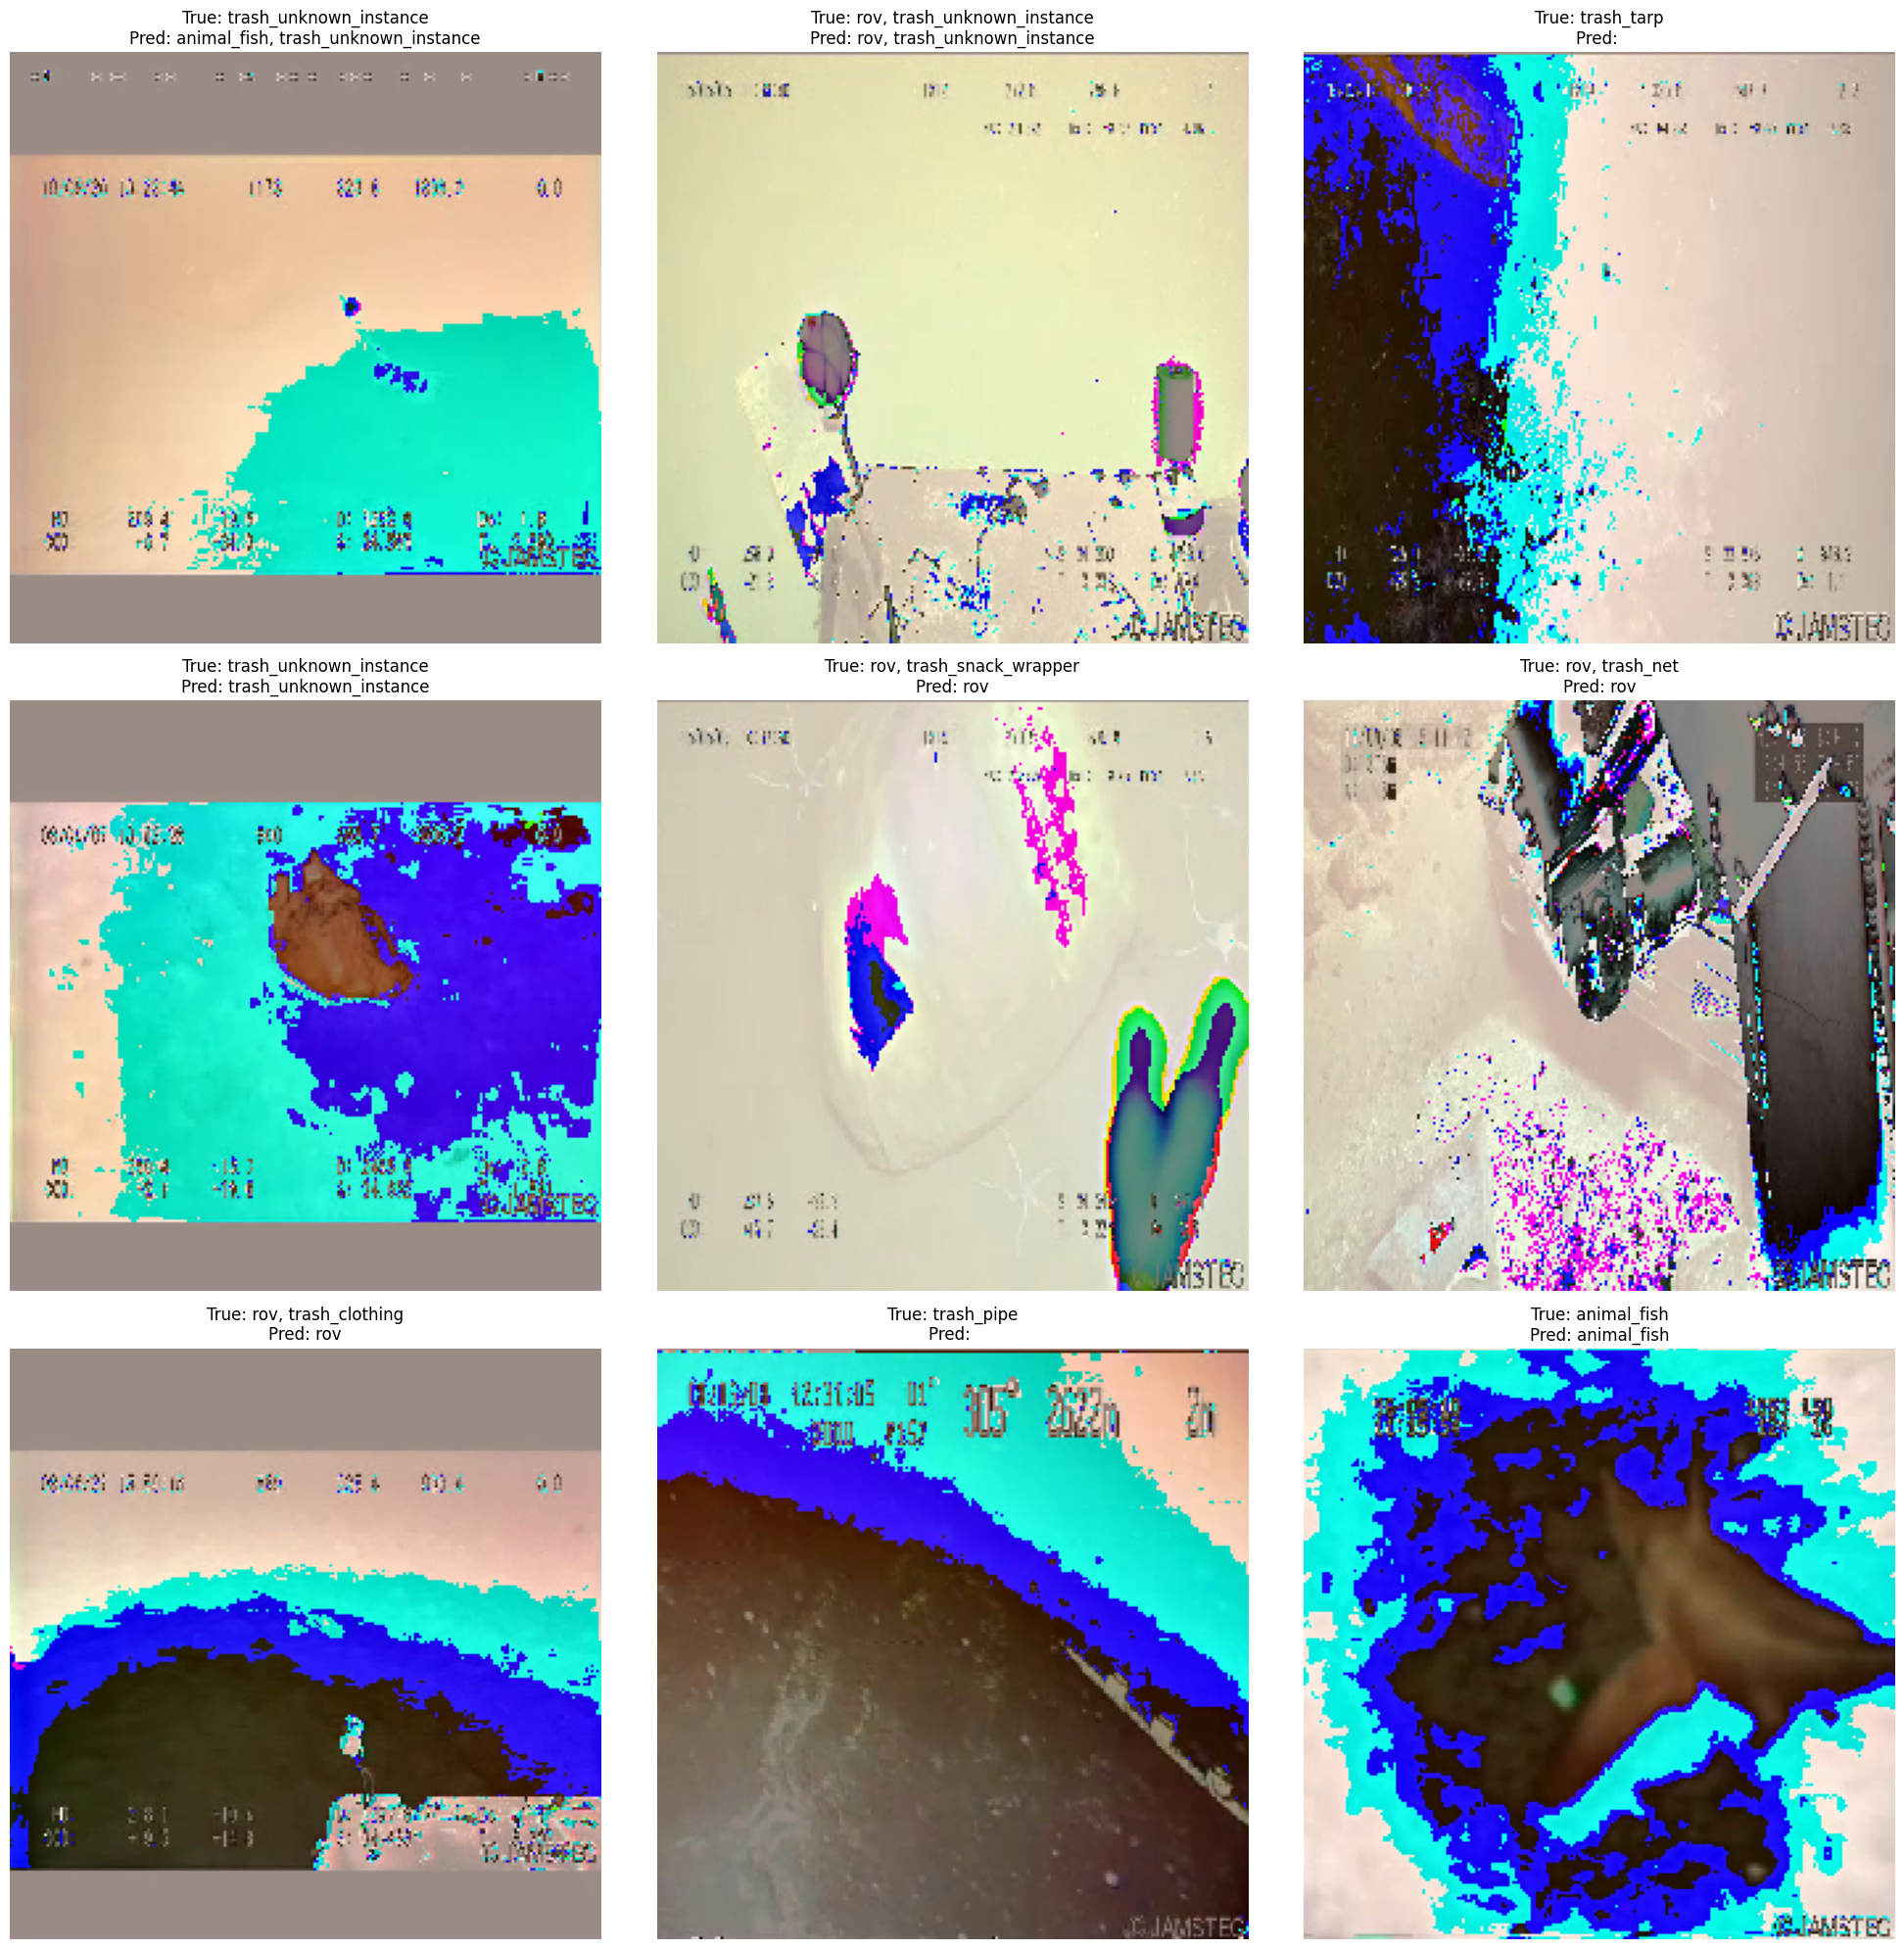

In [30]:
visualize_predictions(cnn_model, val_generator, class_names)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Starting training for vgg16...
Total epochs: 50
Batch size: 32
Steps per epoch: 181
Validation steps: 46

Epoch 1
Train Loss: 0.7271, Train Accuracy: 0.3403
Val Loss: 0.1822, Val Accuracy: 0.5218

Epoch 2
Train Loss: 0.2943, Train Accuracy: 0.4382
Val Loss: 0.1862, Val Accuracy: 0.5322

Epoch 3
Train Loss: 0.2337, Train Accuracy: 0.4363
Val Loss: 0.1421, Val Accuracy: 0.5745

Epoch 4
Train Loss: 0.1999, Train Accuracy: 0.4382
Val Loss: 0.1349, Val Accuracy: 0.5288

Epoch 5
Train Loss: 0.1888, Train Accuracy: 0.4444
Val Loss: 0.1425, Val Accuracy: 0.5683

Epoch 6
Train Loss: 0.1762, Train Accuracy: 0.4658
Val Loss: 0.1238, Val Accuracy: 0.5828

Epoch 7
Train Loss: 0.1703, Train Accuracy: 0.4666
Val Loss: 0.1187, Val Accuracy: 0.6286

Epoch 8
Train Loss: 0.1585, Train Accuracy: 0.4798
Val Loss: 0.1186, Val Accuracy: 0.6286

Epoch 9
Train Loss: 0.1542, Train Accuracy: 0.4812
Val Loss: 0.1167, Val Accuracy: 0.6403

Epoch 10
Train Loss: 0.

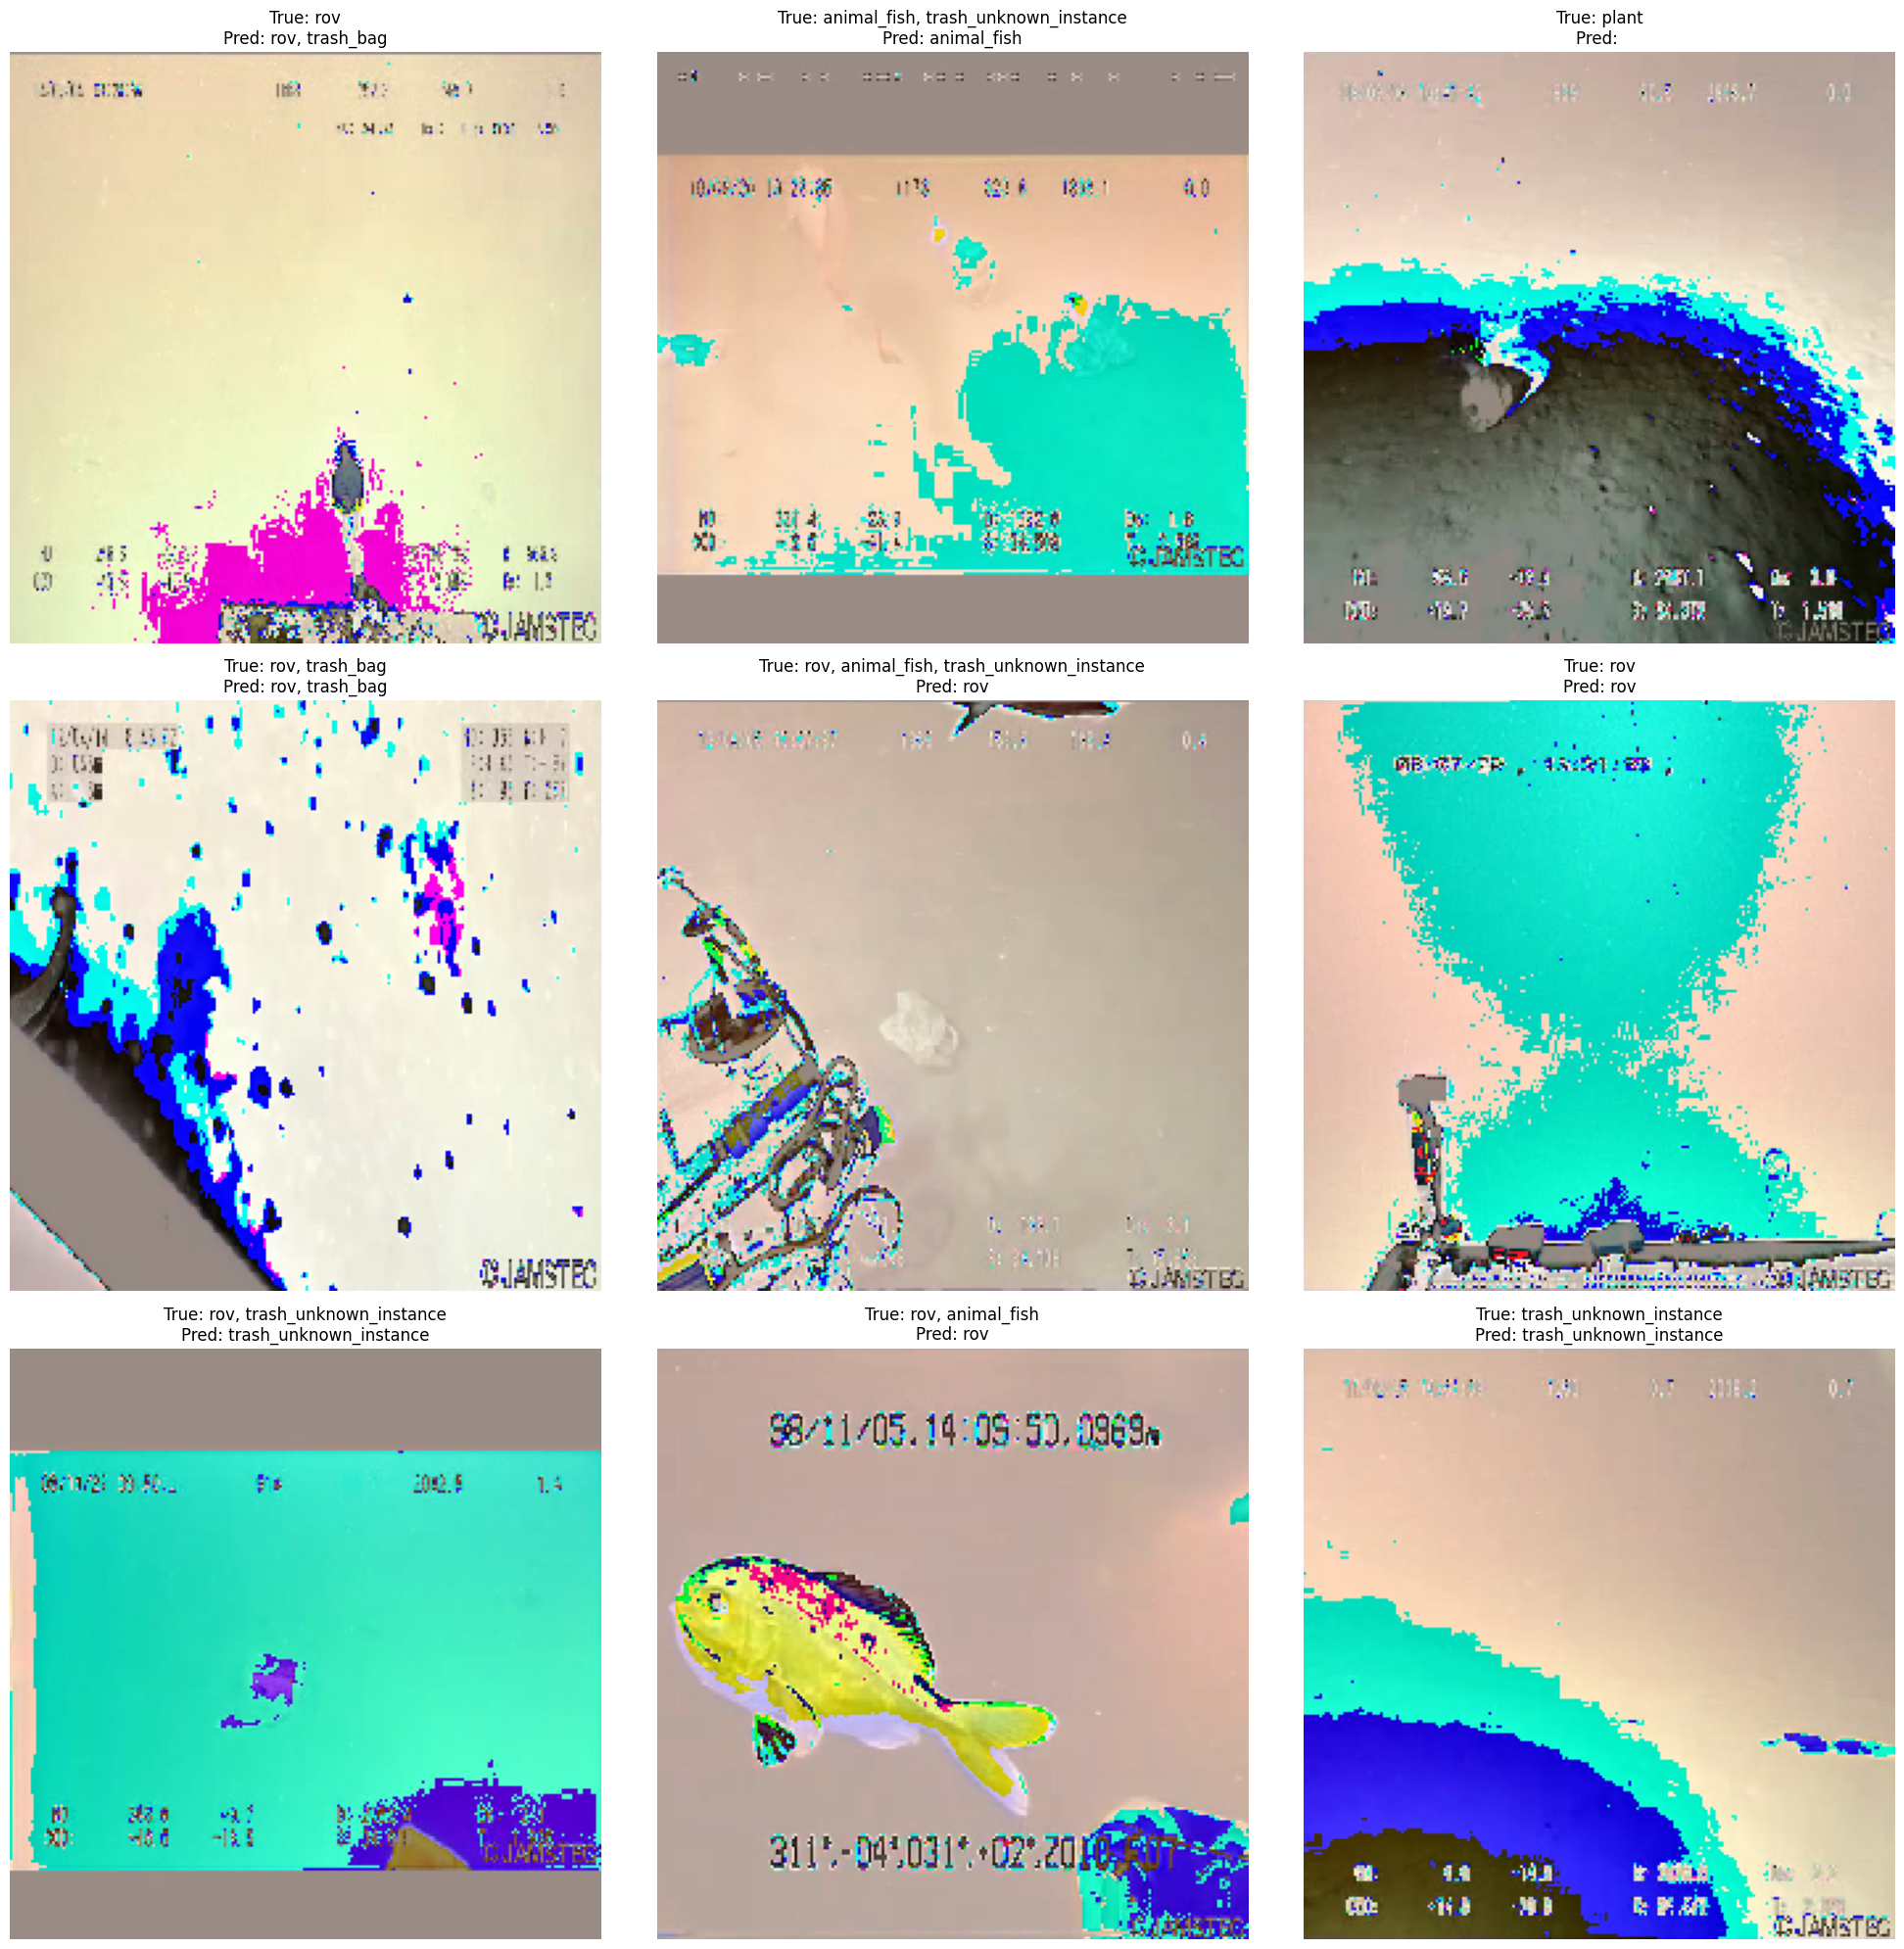

In [31]:
# Train and evaluate VGG16 model
vgg16_model = create_vgg16_model()
vgg16_history = train_model(vgg16_model, 'vgg16')
print("\nVGG16 Model Evaluation:")
evaluate_model(vgg16_model, val_generator)
print("\nVGG16 Model Predictions:")
visualize_predictions(vgg16_model, val_generator, class_names)

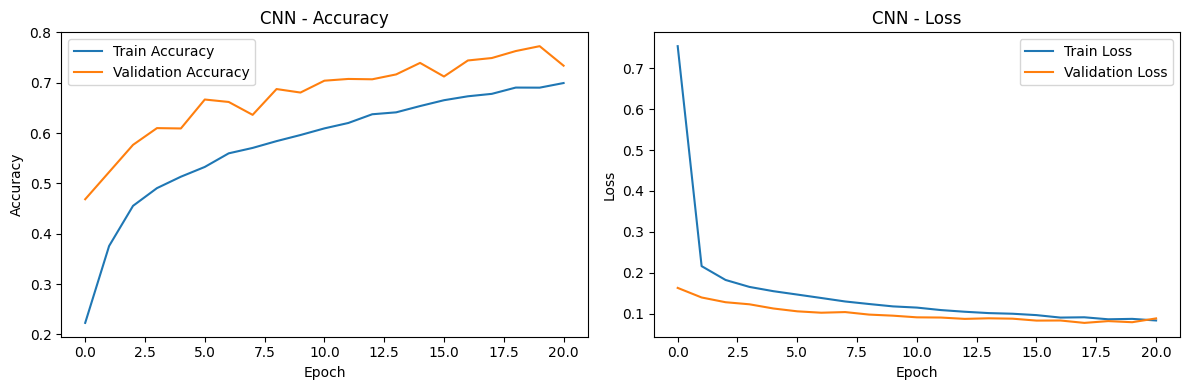

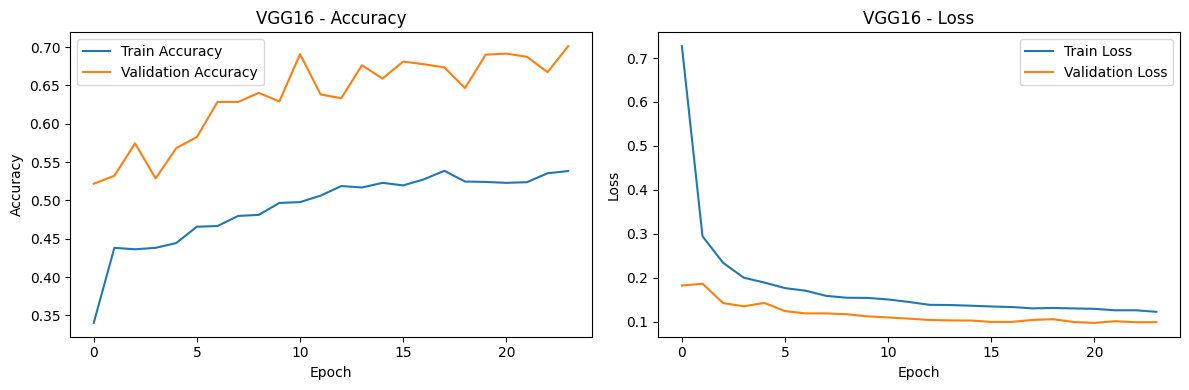

Training completed. Model weights and training history plots have been saved.


In [32]:
# Plot training history
import matplotlib.pyplot as plt

def plot_history(history, model_name):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'{model_name}_training_history.png')
    plt.show()

plot_history(cnn_history, 'CNN')
plot_history(vgg16_history, 'VGG16')

print("Training completed. Model weights and training history plots have been saved.")